In [96]:
from pymongo import MongoClient
from pytz import timezone
from datetime import datetime
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [97]:
def emptyHourTable():
    return [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]


def getLocalTime(time, zone):
    zoneTable = {"International Date Line West":"Pacific/Midway","Midway Island":"Pacific/Midway","American Samoa":"Pacific/Pago_Pago","Hawaii":"Pacific/Honolulu","Alaska":"America/Juneau","Pacific Time (US & Canada)":"America/Los_Angeles","Tijuana":"America/Tijuana","Mountain Time (US & Canada)":"America/Denver","Arizona":"America/Phoenix","Chihuahua":"America/Chihuahua","Mazatlan":"America/Mazatlan","Central Time (US & Canada)":"America/Chicago","Saskatchewan":"America/Regina","Guadalajara":"America/Mexico_City","Mexico City":"America/Mexico_City","Monterrey":"America/Monterrey","Central America":"America/Guatemala","Eastern Time (US & Canada)":"America/New_York","Indiana (East)":"America/Indiana/Indianapolis","Bogota":"America/Bogota","Lima":"America/Lima","Quito":"America/Lima","Atlantic Time (Canada)":"America/Halifax","Caracas":"America/Caracas","La Paz":"America/La_Paz","Santiago":"America/Santiago","Newfoundland":"America/St_Johns","Brasilia":"America/Sao_Paulo","Buenos Aires":"America/Argentina/Buenos_Aires","Montevideo":"America/Montevideo","Georgetown":"America/Guyana","Greenland":"America/Godthab","Mid-Atlantic":"Atlantic/South_Georgia","Azores":"Atlantic/Azores","Cape Verde Is.":"Atlantic/Cape_Verde","Dublin":"Europe/Dublin","Edinburgh":"Europe/London","Lisbon":"Europe/Lisbon","London":"Europe/London","Casablanca":"Africa/Casablanca","Monrovia":"Africa/Monrovia","UTC":"Etc/UTC","Belgrade":"Europe/Belgrade","Bratislava":"Europe/Bratislava","Budapest":"Europe/Budapest","Ljubljana":"Europe/Ljubljana","Prague":"Europe/Prague","Sarajevo":"Europe/Sarajevo","Skopje":"Europe/Skopje","Warsaw":"Europe/Warsaw","Zagreb":"Europe/Zagreb","Brussels":"Europe/Brussels","Copenhagen":"Europe/Copenhagen","Madrid":"Europe/Madrid","Paris":"Europe/Paris","Amsterdam":"Europe/Amsterdam","Berlin":"Europe/Berlin","Bern":"Europe/Berlin","Rome":"Europe/Rome","Stockholm":"Europe/Stockholm","Vienna":"Europe/Vienna","West Central Africa":"Africa/Algiers","Bucharest":"Europe/Bucharest","Cairo":"Africa/Cairo","Helsinki":"Europe/Helsinki","Kyiv":"Europe/Kiev","Riga":"Europe/Riga","Sofia":"Europe/Sofia","Tallinn":"Europe/Tallinn","Vilnius":"Europe/Vilnius","Athens":"Europe/Athens","Istanbul":"Europe/Istanbul","Minsk":"Europe/Minsk","Jerusalem":"Asia/Jerusalem","Harare":"Africa/Harare","Pretoria":"Africa/Johannesburg","Kaliningrad":"Europe/Kaliningrad","Moscow":"Europe/Moscow","St. Petersburg":"Europe/Moscow","Volgograd":"Europe/Volgograd","Samara":"Europe/Samara","Kuwait":"Asia/Kuwait","Riyadh":"Asia/Riyadh","Nairobi":"Africa/Nairobi","Baghdad":"Asia/Baghdad","Tehran":"Asia/Tehran","Abu Dhabi":"Asia/Muscat","Muscat":"Asia/Muscat","Baku":"Asia/Baku","Tbilisi":"Asia/Tbilisi","Yerevan":"Asia/Yerevan","Kabul":"Asia/Kabul","Ekaterinburg":"Asia/Yekaterinburg","Islamabad":"Asia/Karachi","Karachi":"Asia/Karachi","Tashkent":"Asia/Tashkent","Chennai":"Asia/Kolkata","Kolkata":"Asia/Kolkata","Mumbai":"Asia/Kolkata","New Delhi":"Asia/Kolkata","Kathmandu":"Asia/Kathmandu","Astana":"Asia/Dhaka","Dhaka":"Asia/Dhaka","Sri Jayawardenepura":"Asia/Colombo","Almaty":"Asia/Almaty","Novosibirsk":"Asia/Novosibirsk","Rangoon":"Asia/Rangoon","Bangkok":"Asia/Bangkok","Hanoi":"Asia/Bangkok","Jakarta":"Asia/Jakarta","Krasnoyarsk":"Asia/Krasnoyarsk","Beijing":"Asia/Shanghai","Chongqing":"Asia/Chongqing","Hong Kong":"Asia/Hong_Kong","Urumqi":"Asia/Urumqi","Kuala Lumpur":"Asia/Kuala_Lumpur","Singapore":"Asia/Singapore","Taipei":"Asia/Taipei","Perth":"Australia/Perth","Irkutsk":"Asia/Irkutsk","Ulaanbaatar":"Asia/Ulaanbaatar","Seoul":"Asia/Seoul","Osaka":"Asia/Tokyo","Sapporo":"Asia/Tokyo","Tokyo":"Asia/Tokyo","Yakutsk":"Asia/Yakutsk","Darwin":"Australia/Darwin","Adelaide":"Australia/Adelaide","Canberra":"Australia/Melbourne","Melbourne":"Australia/Melbourne","Sydney":"Australia/Sydney","Brisbane":"Australia/Brisbane","Hobart":"Australia/Hobart","Vladivostok":"Asia/Vladivostok","Guam":"Pacific/Guam","Port Moresby":"Pacific/Port_Moresby","Magadan":"Asia/Magadan","Srednekolymsk":"Asia/Srednekolymsk","Solomon Is.":"Pacific/Guadalcanal","New Caledonia":"Pacific/Noumea","Fiji":"Pacific/Fiji","Kamchatka":"Asia/Kamchatka","Marshall Is.":"Pacific/Majuro","Auckland":"Pacific/Auckland","Wellington":"Pacific/Auckland","Nuku'alofa":"Pacific/Tongatapu","Tokelau Is.":"Pacific/Fakaofo","Chatham Is.":"Pacific/Chatham","Samoa":"Pacific/Apia"}
    offset = timezone(zoneTable[zone]).utcoffset(datetime.now())
    return time + offset

def getTweetHour(tweet):
    zone = tweet["user"]["time_zone"]
    return getLocalTime(tweet["created_at"], zone).hour



def getUserFrequency(collectionName, timeZone=True, regularization=True, percentage = False):

    client = MongoClient('localhost', 27017)
    collection = client['idea'][collectionName]
    userFrequency = {}

    for tweet in collection.find():
        zone = tweet["user"]["time_zone"]
        if zone is not None:
            userID = tweet["user"]["id"]
            hour = getTweetHour(tweet)
            
            if userID not in userFrequency:
                userFrequency[userID] = emptyHourTable()
            userFrequency[userID][hour] += 1
    
    if regularization:
        for userID in userFrequency:
            total = sum(userFrequency[userID])
            if percentage:
                total /= 100
            for i in range(24):
                userFrequency[userID][i] /=  total
            
    return userFrequency


def frequencyPlot(userFrequency):
   
    X = []
    Y = []
    for hourTable in userFrequency.values():
        for i in range(24):
            if hourTable[i] < 0.3:
                X.append(i)
                Y.append(hourTable[i])
    X = np.array(X)
    Y = np.array(Y)
    fig, ax = plt.subplots()
    fit = np.polyfit(X, Y, deg=1)
    ax.plot(X, fit[0] * X + fit[1], color='red')
    ax.scatter(X, Y)

    fig.show()
    
def averagePlot(userFrequency, title):
    
    X = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    Y = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for hourTable in userFrequency.values():
        for i in range(24): 
            Y[i] += hourTable[i]
    X = np.array(X)
    Y = np.array(Y)
    Y /= len(userFrequency)
    fig, ax = plt.subplots()
    fit = np.polyfit(X, Y, deg=3)
    ax.plot(X, fit[0] * X**3+ + fit[1]*X**2+fit[2]*X+fit[3], color='red')
    ax.scatter(X, Y)
    ax.set_xlabel("Hour",  fontsize=14)
    ax.set_ylabel("Probablity to Post",  fontsize=14)
    fig.suptitle("{} {} people".format(len(userFrequency), title),  fontsize=18)
    
    fig.show()   

  

def personalPlot(userHour):  
        
    X = []
    Y = []

    for i in range(24):
        if userHour[i] > 0:
            X.append(i)
            Y.append(userHour[i])
            
    X = np.array(X)
    Y = np.array(Y)
    fig, ax = plt.subplots()
   
    fit = np.polyfit(X, Y, deg=2)
    ax.plot(X, fit[0] * X**2+ + fit[1]*X+fit[2], color='red')
    ax.scatter(X, Y)
    plt.axis((0,24,0,0.2))
    fig.show()
  
    
    
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    return sqrt(LB_sum)

In [98]:
regularUserFrequency = getUserFrequency("regularUser_en_fixed")
BPDUserFrequency = getUserFrequency("BPD_fixed")

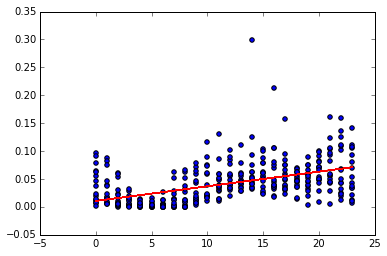

In [99]:
frequencyPlot(BPDUserFrequency)
        

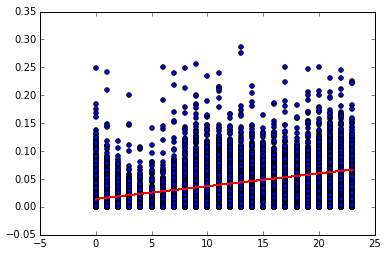

In [100]:
frequencyPlot(regularUserFrequency)

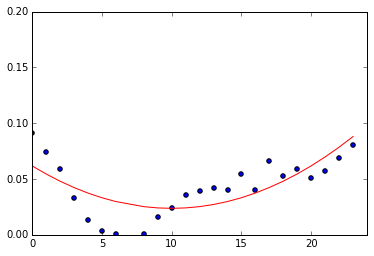

In [101]:
personalPlot(list(BPDUserFrequency.values())[11])

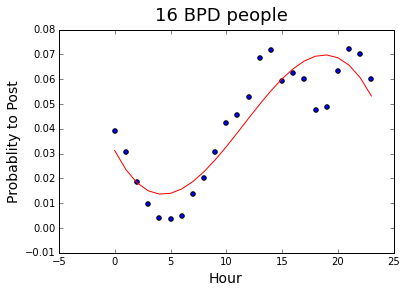

In [102]:
averagePlot(BPDUserFrequency, "BPD")   #16位有時區的BPD患者

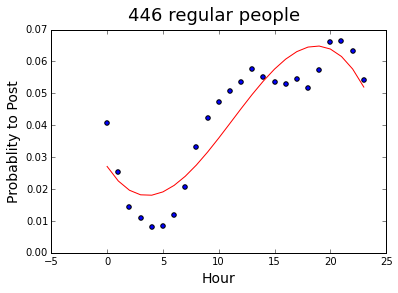

In [103]:
averagePlot(regularUserFrequency, "regular")   #446位有時區的一般使用者